# Data analysis on main phase 2+1D CDT

Author: Seda den Boer

Date: 04/04/2024

In [380]:
# Load packages
import sys
sys.path.append('..')
from classes.universe import Universe
from classes.helper_functions.helpers import get_spatial_neighbours, get_vertices_in_slice
from typing import Dict, List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import os
from mpl_toolkits.mplot3d import Axes3D
import random
import glob

## Experiment parameters

In [3]:
chains = 16
k0_values = np.arange(0.0, 8.0, 1.0)
T = 10
thermal_sweeps = 1000
sweeps = 0
target_volume = 3000
ksteps = 300000

# k0 to make plots for
k0 = 7.0

## $<N_{22}/N_{31}>$

### Phase transition

## Volume

### Spatial volume

### Total tetrahedron volume

## Curvature

## Spectral dimension

## Autocorrelation time

In [387]:
def acf(series):
    n = len(series)
    data = np.asarray(series)
    mean = np.mean(data)
    c0 = np.sum((data - mean) ** 2) / float(n)

    def r(h):
        acf_lag = ((data[:n - h] - mean) * (data[h:] - mean)).sum() / float(n) / c0
        return round(acf_lag, 3)
    
    x = np.arange(1, n) # Avoiding lag 0 calculation
    acf_coeffs = map(r, x)
    return list(acf_coeffs)  # Convert generator to list

<>:75: SyntaxWarning: invalid escape sequence '\w'
<>:75: SyntaxWarning: invalid escape sequence '\w'
C:\Users\sedad\AppData\Local\Temp\ipykernel_18336\935147953.py:75: SyntaxWarning: invalid escape sequence '\w'
  plt.suptitle(f'Autocorrelation of $N_{{22}}/N_{{31}}$ for different $k_0$ values in tuning phase\n($T={T}$, $\widetilde{{N}}_{{31}}$ = {n})', fontsize=16, y=1.0)


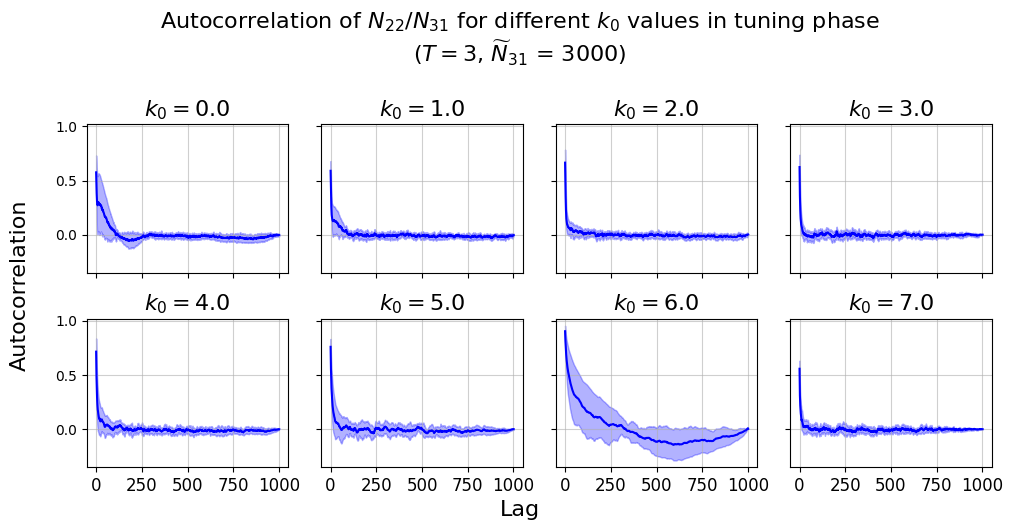

In [488]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf

T = 3
n = 3000
k0_values = np.arange(0.0, 8.0, 1.0)

fig, ax = plt.subplots(2, 4, figsize=(10, 5), sharex=True, sharey=True)

for i, k0 in enumerate(k0_values):
    # Load data of thermal sweeps
    DIR_MAIN = f'measurements_final/k0={k0}'
    filepaths_n22_main = glob.glob(f'{DIR_MAIN}/T{T}*kstps={n * 100}*n_tetras_22.npy')
    filepaths_n31_main = glob.glob(f'{DIR_MAIN}/T{T}*kstps={n * 100}*n_tetras_31.npy')

    # Get the chains of main it can be found by finding 'chain={}_' in the filepath
    chains = []
    for filepath in filepaths_n22_main:
        chain = int(filepath.split('chain=')[1].split('_')[0])
        chains.append(chain)

    DIR_THERMAL = f'measurements_thermal/k0={k0}'
    filepaths_n22_thermal = []
    filepaths_n31_thermal = []

    for chain in chains:
        filepaths_n22_thermal.append(glob.glob(f'{DIR_THERMAL}/T{T}*kstps={n * 100}*chain={chain}_n_tetras_22.npy')[0])
        filepaths_n31_thermal.append(glob.glob(f'{DIR_THERMAL}/T{T}*kstps={n * 100}*chain={chain}_n_tetras_31.npy')[0])

    n22_n31_thermal = []
    n22_n31_main = []

    for j in range(len(filepaths_n22_thermal)):
        n22_thermal = np.load(filepaths_n22_thermal[j])
        n31_thermal = np.load(filepaths_n31_thermal[j])
        n22_main = np.load(filepaths_n22_main[j])
        n31_main = np.load(filepaths_n31_main[j])
        n22_n31_thermal.append(n22_thermal / n31_thermal)
        n22_n31_main.append(n22_main / n31_main)


    n22_n31_thermal = np.array(n22_n31_thermal)
    n22_n31_main = np.array(n22_n31_main)

    # Make it a df
    df = pd.DataFrame(n22_n31_thermal).T

    # Add the main data
    df_main = pd.DataFrame(n22_n31_main).T
    df = pd.concat([df, df_main], axis=0)
    # display(df)

    # Calculate the autocorrelation for each column in the df
    acfs = []
    for column in df.columns:
        acfs.append(acf(df[column]))

    acfs = np.array(acfs)
    acfs_mean = np.mean(acfs, axis=0)
    acfs_std = np.std(acfs, axis=0)

    ax[i // 4, i % 4].set_title(f'$k_0={k0}$', fontsize=16)
    ax[i // 4, i % 4].plot(acfs_mean, color='blue')
    ax[i // 4, i % 4].fill_between(np.arange(len(acfs_mean)), acfs_mean - acfs_std, acfs_mean + acfs_std, color='blue', alpha=0.3)
    ax[i // 4, i % 4].grid(which='both', ls="-", alpha=0.6)
    x_labels = ['0', '250', '500', '750', '1000']
    ax[i // 4, i % 4].set_xticks([0, 250, 500, 750, 1000])
    ax[i // 4, i % 4].set_xticklabels(x_labels, fontsize=12)

# Set shared axis labels
fig.text(0.5, 0.0, 'Lag', ha='center', va='center', fontsize=16)
fig.text(0.0, 0.45, 'Autocorrelation', ha='center', va='center', rotation='vertical', fontsize=16)

# Set overall title
plt.suptitle(f'Autocorrelation of $N_{{22}}/N_{{31}}$ for different $k_0$ values in tuning phase\n($T={T}$, $\widetilde{{N}}_{{31}}$ = {n})', fontsize=16, y=1.0)
plt.tight_layout() 
plt.savefig(f'plots/autocorrelation/thermal_autocorrelation_N22_N31_T{T}_N31_{n}.png', bbox_inches='tight', dpi=400)


<>:84: SyntaxWarning: invalid escape sequence '\w'
<>:84: SyntaxWarning: invalid escape sequence '\w'
C:\Users\sedad\AppData\Local\Temp\ipykernel_18336\3955298549.py:84: SyntaxWarning: invalid escape sequence '\w'
  plt.suptitle(f'Autocorrelation of $N_{{22}}/N_{{31}}$ for different $k_0$ values after tuning phase\n($T={T}$, $\widetilde{{N}}_{{31}}$ = {n})', fontsize=16, y=1.0)


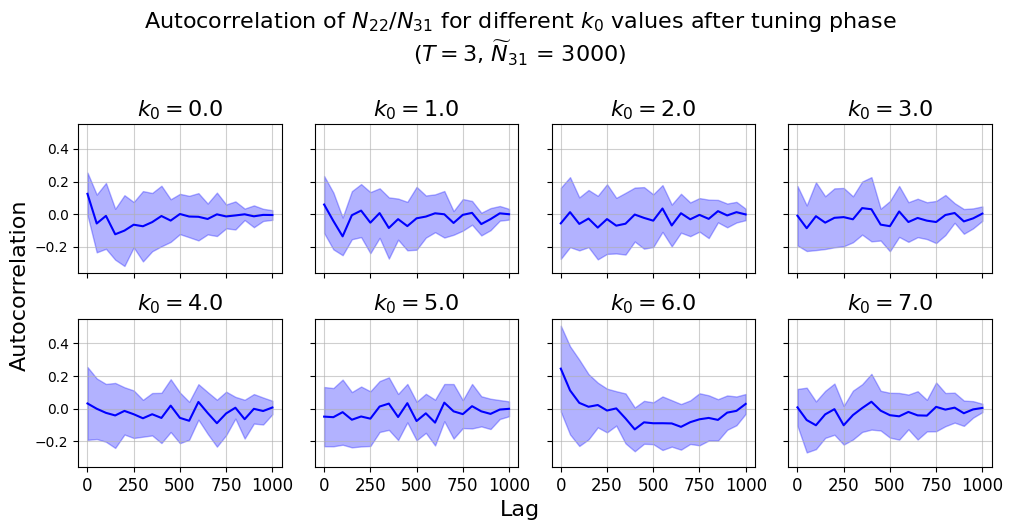

In [489]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf

T = 3
n = 3000
k0 = 0.0

k0_values = np.arange(0.0, 8.0, 1.0)

fig, ax = plt.subplots(2, 4, figsize=(10, 5), sharex=True, sharey=True)
for i, k0 in enumerate(k0_values):
        
    # Load data of thermal sweeps
    DIR_MAIN = f'measurements_main/k0={k0}'
    filepaths_n22_main = glob.glob(f'{DIR_MAIN}/T{T}*kstps={n * 100}*n_tetras_22.npy')
    filepaths_n31_main = glob.glob(f'{DIR_MAIN}/T{T}*kstps={n * 100}*n_tetras_31.npy')

    # Get the chains of main it can be found by finding 'chain={}_' in the filepath
    chains = []
    for filepath in filepaths_n22_main:
        chain = int(filepath.split('chain=')[1].split('_')[0])
        chains.append(chain)

    DIR_THERMAL = f'measurements_thermal/k0={k0}'
    filepaths_n22_thermal = []
    filepaths_n31_thermal = []

    for chain in chains:
        filepaths_n22_thermal.append(glob.glob(f'{DIR_THERMAL}/T{T}*kstps={n * 100}*chain={chain}_n_tetras_22.npy')[0])
        filepaths_n31_thermal.append(glob.glob(f'{DIR_THERMAL}/T{T}*kstps={n * 100}*chain={chain}_n_tetras_31.npy')[0])

    n22_n31_thermal = []

    for j in range(len(filepaths_n22_thermal)):
        n22_thermal = np.load(filepaths_n22_thermal[j])
        n31_thermal = np.load(filepaths_n31_thermal[j])
        n22_n31_thermal.append(n22_thermal / n31_thermal)

    n22_n31_thermal = np.array(n22_n31_thermal)

    # Only save the last value of the thermal sweeps
    n22_n31_thermal = n22_n31_thermal[:, -1]

    # Make it a df
    df_thermal = pd.DataFrame(n22_n31_thermal).T
        
    # Open the data
    n22_n31_main = []
    for j in range(len(filepaths_n22_main)):
        n22_main = np.load(filepaths_n22_main[j])
        n31_main = np.load(filepaths_n31_main[j])
        n22_n31_main.append(n22_main / n31_main)

    n22_n31_main = np.array(n22_n31_main)

    # Make it a df
    df = pd.DataFrame(n22_n31_main).T

    # Add the thermal data as the first row
    df = pd.concat([df_thermal, df], axis=0)
    
    # Calculate the autocorrelation for each column in the df
    acfs = []
    for column in df.columns:
        acfs.append(acf(df[column]))

    acfs = np.array(acfs)
    acfs_mean = np.mean(acfs, axis=0)
    acfs_std = np.std(acfs, axis=0)

    ax[i // 4, i % 4].set_title(f'$k_0={k0}$', fontsize=16)
    ax[i // 4, i % 4].plot(acfs_mean, color='blue')
    ax[i // 4, i % 4].fill_between(np.arange(len(acfs_mean)), acfs_mean - acfs_std, acfs_mean + acfs_std, alpha=0.3, color='blue')
    ax[i // 4, i % 4].grid(which='both', ls="-", alpha=0.6)
    x_labels = ['0', '250', '500', '750', '1000']
    ax[i // 4, i % 4].set_xticks([0, 5, 10, 15, 20])
    ax[i // 4, i % 4].set_xticklabels(x_labels, fontsize=12)

# Set shared axis labels
fig.text(0.5, 0.0, 'Lag', ha='center', va='center', fontsize=16)
fig.text(0.0, 0.45, 'Autocorrelation', ha='center', va='center', rotation='vertical', fontsize=16)

# Set overall title
plt.suptitle(f'Autocorrelation of $N_{{22}}/N_{{31}}$ for different $k_0$ values after tuning phase\n($T={T}$, $\widetilde{{N}}_{{31}}$ = {n})', fontsize=16, y=1.0)
plt.tight_layout() 
plt.savefig(f'plots/autocorrelation/main_autocorrelation_N22_N31_T{T}_N31_{n}.png', bbox_inches='tight', dpi=400)

## Visualisation

### Network timeslices

In [354]:

def generate_timeslice_graphs(universe: Universe, save: bool, filename: str) -> Dict[int, nx.Graph]:
    T = universe.n_slices
    vertices_in_slice = get_vertices_in_slice(universe)
    spatial_neighbours = get_spatial_neighbours(universe)
    for key, value in spatial_neighbours.items():
        if key in value:
            value.remove(key)
            
    graphs = {t: None for t in range(T)}

    print(spatial_neighbours)

    # Generate the graph
    for t, vertex_ids in vertices_in_slice.items():
        G = nx.Graph()

        for vertex_id in vertex_ids:
            vertex = universe.vertex_pool.get(vertex_id)
            G.add_node(
                vertex_id,
                time=vertex.time,
                tetrahedron=vertex.tetra.ID,
                degree=len(universe.vertex_neighbours[vertex.ID]),
                cnum=vertex.cnum,
                scnum=vertex.scnum,
            )
        
        for vertex_id in vertex_ids:
            for spatial_neighbour_id in spatial_neighbours[vertex_id]:
                G.add_edge(vertex_id, spatial_neighbour_id)

        pos = nx.planar_layout(G)
        
        for node,(x,y) in pos.items():
            G.nodes[node]['x'] = float(x)
            G.nodes[node]['y'] = float(y)

        graphs[t] = G

        if nx.check_planarity(G):
            print(f'The spatial slice {t} is planar')
        else:
            print(f'The spatial slice {t} is not planar')
            
        if save:
            nx.write_gexf(G, f'{filename}_t={t}.gexf')
    
    return graphs

def visualise_timeslices(graphs: Dict[int, nx.Graph], outfile: str, k0: float, N: int):
    # Plot each graph 3 in a row and just 1 row 
    fig, axs = plt.subplots(1, len(graphs), figsize=(20, 5))

    for t, G in graphs.items():
        pos = nx.spring_layout(G, k=0.1)
        # Node_sizes hsould be the 'scnum' attribute
        node_sizes = [G.nodes[node]['scnum'] for node in G.nodes]
        scaled_node_sizes = [size**1.6 for size in node_sizes]
        nx.draw(G, pos, node_size=scaled_node_sizes, node_color="blue", ax=axs[t])
        axs[t].set_title(f"$t$ = {t}", fontsize=20)
        axs[t].axis("equal")

    fig.suptitle(f"Timeslice graphs for $k_0$ = {k0} with $\widetilde{{N}}_{{31}}$ = {N}", fontsize=20, y=1.05)
    plt.tight_layout()
    plt.savefig(outfile, dpi=400, bbox_inches="tight")
    

<>:63: SyntaxWarning: invalid escape sequence '\w'
<>:63: SyntaxWarning: invalid escape sequence '\w'
C:\Users\sedad\AppData\Local\Temp\ipykernel_18336\2057817864.py:63: SyntaxWarning: invalid escape sequence '\w'
  fig.suptitle(f"Timeslice graphs for $k_0$ = {k0} with $\widetilde{{N}}_{{31}}$ = {N}", fontsize=20, y=1.05)


In [309]:
k0 = 7.0
T = 3
N = 3000
chain = int(k0)
ksteps = N * 100

file = f'saved_universes_final/k0={k0}/T{T}_k0={k0}_tswps=0_swps=1_kstps={ksteps}_chain={chain}_main_1.txt'
universe = Universe(geometry_infilename=file)
universe.update_vertices()


n0: 1506
n3: 6017
Read and loaded saved_universes_final/k0=7.0/T3_k0=7.0_tswps=0_swps=1_kstps=300000_chain=7_main_1.txt.


In [352]:
graphs = generate_timeslice_graphs(universe, save=True, filename=f'graphs/spatial_k0={k0}_T={T}_N={N}_chain={chain}')


{0: [2, 136, 317, 430, 465, 518, 711], 1: [898, 972, 1101, 253, 926], 2: [0, 518, 136, 790, 317, 941, 465], 3: [291, 1284, 710, 822, 1342], 4: [935, 558, 720, 83, 468, 755, 1334, 538, 1338, 1019], 5: [564, 341, 1398, 1439], 6: [1056, 583, 285], 7: [225, 195, 421, 845, 751, 17, 467, 1367], 8: [14, 65, 321, 378, 569, 610, 924, 1237, 1502], 9: [451, 421, 363, 1363, 406, 251], 10: [1188, 487, 490, 620, 469, 473, 410, 1181, 1310], 11: [1248, 772, 942, 847, 207, 1135, 1202, 179, 761], 12: [813, 332, 49, 818, 1267, 1116, 638], 13: [1472, 163, 35, 137, 1130, 779, 683, 1485, 15, 529, 245, 282, 1052, 125, 990], 14: [65, 8, 924], 15: [137, 1353, 13, 52, 1052], 16: [1159, 110, 1076, 542], 17: [195, 7, 845, 1214], 18: [1184, 1352, 139, 236, 1036, 1102, 945, 1298, 530, 469, 984, 1049, 255], 19: [1035, 176, 883], 20: [292, 1029, 1445, 521, 330, 663, 1453, 1039, 592, 758, 759, 313, 794, 541, 862], 21: [1287, 204, 630, 988], 22: [616, 490, 626, 469], 23: [480, 1002, 650, 1067, 398, 1041, 281, 442, 183]

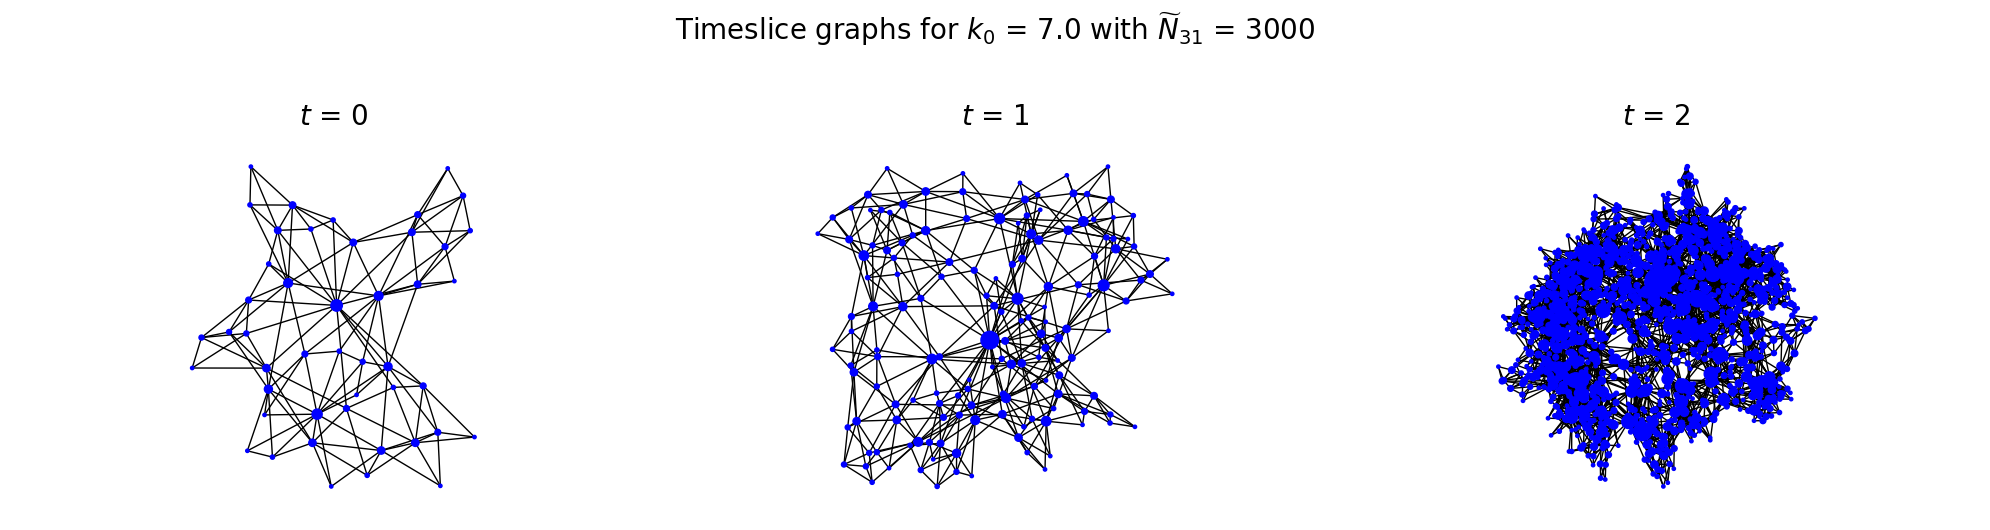

In [355]:
visualise_timeslices(graphs, outfile=f'graphs/spatial_k0={k0}_T={T}_N={N}_chain={chain}.png', k0=k0, N=N)

### Triangulation timeslices

In [249]:
def f(x, data):
    return data[-1][x]

<>:25: SyntaxWarning: invalid escape sequence '\w'
<>:25: SyntaxWarning: invalid escape sequence '\w'
C:\Users\sedad\AppData\Local\Temp\ipykernel_18336\805383266.py:25: SyntaxWarning: invalid escape sequence '\w'
  ax.set_title(f'Spatial volume distribution for $k_0={k0}$ with $\widetilde{{N}}_{{31}}$={N}', fontsize=20)


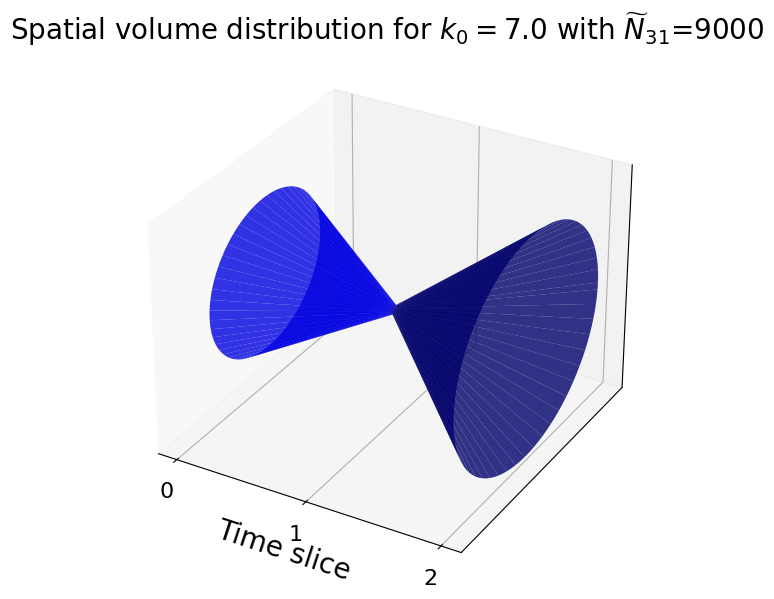

In [324]:
k0 = 7.0
T = 3
N = 9000
chain = int(k0) + 32
ksteps = N * 100

filepath = f'measurements_final/k0={k0}/T{T}_k0={k0}_tswps=0_swps=1_kstps={ksteps}_chain={chain}_slice_sizes.npy'
slice_sizes = np.load(filepath)

# Generate points along the function
x = np.arange(T)
y = [f(x, slice_sizes) for x in x]

# Revolve the profile around an axis
theta = np.linspace(0, 2 * np.pi, 100)
X, Theta = np.meshgrid(x, theta)
Y = np.cos(Theta) * y
Z = np.sin(Theta) * y

# Plot the 3D object
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, color='b', alpha=0.8)
ax.set_xlabel('Time slice', fontsize=20)
ax.set_title(f'Spatial volume distribution for $k_0={k0}$ with $\widetilde{{N}}_{{31}}$={N}', fontsize=20)
ax.set_yticks([])
ax.set_zticks([])
ax.set_xticks(x)
ax.tick_params(axis='both', which='major', labelsize=16)
savepath = f'plots/visualisation/T{T}/N{N}/T{T}_spatial_volume_k0={k0}_tswps={thermal_sweeps}_chain={chain}.png'
if not os.path.exists(f'plots/visualisation/T{T}/N{N}'):
    os.makedirs(f'plots/visualisation/T{T}/N{N}')
plt.savefig(savepath, dpi=400, bbox_inches='tight')

In [220]:
# def generate_random_data(length, total):
#     data = []
#     remaining = total
#     for _ in range(length - 1):
#         value = random.uniform(0, remaining)
#         data.append(value)
#         remaining -= value
#     data.append(remaining)
#     random.shuffle(data)
#     return data

# # Step 2: Generate points along the function
# x = [0, 1, 2, 3, 4]
# length = 5
# total = 5000
# y = generate_random_data(length, total)

# # Step 3: Revolve the profile around an axis
# theta = np.linspace(0, 2 * np.pi, 100)
# X, Theta = np.meshgrid(x, theta)
# Y = np.cos(Theta) * y
# Z = np.sin(Theta) * y

# # Step 4: Plot the 3D object
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(X, Y, Z, color='b')
# # Dont show y and z axis
# ax.set_yticks([])
# ax.set_zticks([])